# Moving Average
This strategy does not look at the current price but instead at the moving average of the price pa. We will consider different time intervals for calculating the moving average: two hours, six hours, one day, seven days, 30 days, 100 days, and 200 days. The liquidity position of this strategy will be [pa − a, pa + a]. As in the constant interval strategy 4.3, the leftover token will not be used to provide any liquidity.

Import code dependencies

In [21]:
import math
from datetime import date, timedelta

import pandas as pd

from demeter import TokenInfo, Actuator, Strategy, RowData, simple_moving_average, ChainType, MarketInfo, PeriodTrigger, \
    BaseAction
from demeter.result import performance_metrics
from demeter.uniswap import UniV3Pool, UniLpMarket
from typing import List
from demeter.broker import AccountStatus
from matplotlib.pylab import plt
import matplotlib.dates as mdates
#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


Set pandas output format

In [2]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Moving Average strategy with code to add liquidity at window's average price.

In [22]:
class MovingAverageStrategy(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """

        # Add a simple moving average line for backtesting data. In backtesting,
        # we will add/remove liquidity according to this line.
        self.add_column(market_key, "sma", simple_moving_average(self.data[market_key].price, window=timedelta(hours=1)))
        self.net_value_before_bar = 0
        self.net_value_diff_list = []
        # Register a trigger, every day, we split both assets into two shares of equal value
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=3), trigger_immediately=True, do=self.rebalance))

    def rebalance(self, row_data: RowData):
        self.markets[market_key].even_rebalance(row_data.market_status[market_key].price)

    """
    After a test is executed, actuator will loop the data, and bar series functions will be called on every time.
    Here you can set conditions and execute liquidity operations
    """

    def on_bar(self, row_data: RowData):
        """
        This function is called after trigger, but before market is updated(Fees will be distributed in this step).
        """
        lp_market: UniLpMarket = self.markets[market_key]
        current_price = row_data.market_status[market_key].price
        # get moving average price, if value is nan, fill it with current price
        ma_price = self.data[market_key].loc[row_data.timestamp]["sma"]
        ma_price = row_data.market_status[market_key].price if math.isnan(ma_price) else ma_price

        # this is a nonsense strategy, just to show how to trigger actions
        if row_data.market_status[market_key].price > ma_price + 25 and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price, current_price + 100)
        elif row_data.market_status[market_key].price < ma_price - 25 and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price - 100, current_price)

    def after_bar(self, row_data: RowData):
        """
        this function is called after market has updated.
        """
        timestamp = row_data.timestamp
        net_value_after_bar = self.broker.get_account_status(self.prices.loc[timestamp]).net_value
        net_value_diff = net_value_after_bar - self.net_value_before_bar
        self.net_value_diff_list.append(net_value_diff)

    def finalize(self):
        """
        Call when main loop finished. some statistic work can be executed here
        """
        self.data[market_key]["diff"] = self.net_value_diff_list
        pass

    def notify(self, action: BaseAction):
        """
        When a new action(add/remove liquidity) is executed, you can be notified by this call back.
        """
        print("\n")
        print(action.timestamp, action.action_type.value)

Main logic to run Actuator, init two token and market with key "market1"

In [23]:
usdc = TokenInfo(name="usdc", decimal=6)  # TokenInfo(name='usdc', decimal=6)
eth = TokenInfo(name="eth", decimal=18)  # TokenInfo(name='eth', decimal=18)
pool = UniV3Pool(
    usdc, eth, 0.05, usdc
)  # PoolBaseInfo(Token0: TokenInfo(name='usdc', decimal=6),Token1: TokenInfo(name='eth', decimal=18),fee: 0.0500,base token: usdc)

market_key = MarketInfo("market1")  # market1
market = UniLpMarket(market_key, pool)
market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 15), date(2023, 8, 15))

actuator = Actuator()  # init actuator
actuator.broker.add_market(market)  # add market to actuator
actuator.broker.set_balance(usdc, 10000)  # set balance
actuator.broker.set_balance(eth, 10)  # set balance
actuator.strategy = MovingAverageStrategy()  # set strategy
actuator.set_price(market.get_price_from_data())  # set actuator price

# actuator.run()  # run actuator

2024-10-05 17:39:06,730 - INFO - start load files from 2023-08-15 to 2023-08-15...
2024-10-05 17:39:06,747 - INFO - load file complete, preparing...
2024-10-05 17:39:06,786 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [24]:
actuator.run()
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})


2024-10-05 17:39:07,819 - INFO - Qute token is USDC
2024-10-05 17:39:07,819 - INFO - init strategy...
2024-10-05 17:39:07,824 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 6848.76it/s]
2024-10-05 17:39:08,037 - INFO - main loop finished




2023-08-15 00:00:00 sell


2024-10-05 17:39:08,057 - INFO - Print actuator summary
2024-10-05 17:39:08,061 - INFO - Backtesting finished, execute time 0.24396276473999023s


Final account status                              
Token balance in broker       
USDC      :14217.417                ETH       :7.7113740                
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Quote by: USDC
Account balance history                           
l1                  net_value    tokens            market1                                                                                          price     
l2                                 USDC      ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-15 00:00:00 28434.834 14217.417 7.711374         0                0                 0                0                 0              0 1843.6944    1
2023-08-15 00:01:00 28434.834 14217.417 7.711374         0                0

In [25]:
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_80905/242916292.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


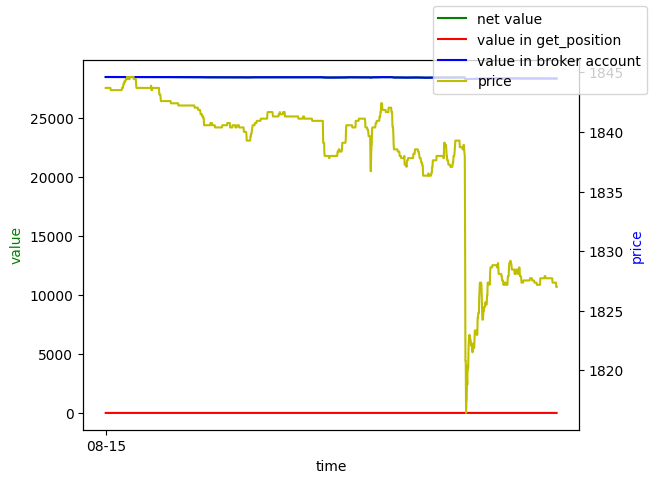

In [27]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)

### Let's try it with Etherum data

In [36]:
class MovingAverageStrategy(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """

        # Add a simple moving average line for backtesting data. In backtesting,
        # we will add/remove liquidity according to this line.
        self.add_column(market_key, "sma", simple_moving_average(self.data[market_key].price, window=timedelta(hours=1)))
        self.net_value_before_bar = 0
        self.net_value_diff_list = []
        # Register a trigger, every day, we split both assets into two shares of equal value
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=3), trigger_immediately=True, do=self.rebalance))

    def rebalance(self, row_data: RowData):
        self.markets[market_key].even_rebalance(row_data.market_status[market_key].price)

    """
    After a test is executed, actuator will loop the data, and bar series functions will be called on every time.
    Here you can set conditions and execute liquidity operations
    """

    def on_bar(self, row_data: RowData):
        """
        This function is called after trigger, but before market is updated(Fees will be distributed in this step).
        """
        lp_market: UniLpMarket = self.markets[market_key]
        current_price = row_data.market_status[market_key].price
        # get moving average price, if value is nan, fill it with current price
        ma_price = self.data[market_key].loc[row_data.timestamp]["sma"]
        ma_price = row_data.market_status[market_key].price if math.isnan(ma_price) else ma_price

        # this is a nonsense strategy, just to show how to trigger actions
        if row_data.market_status[market_key].price > ma_price  and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price, current_price + 100)
        elif row_data.market_status[market_key].price < ma_price  and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price - 100, current_price)

    def after_bar(self, row_data: RowData):
        """
        this function is called after market has updated.
        """
        timestamp = row_data.timestamp
        net_value_after_bar = self.broker.get_account_status(self.prices.loc[timestamp]).net_value
        net_value_diff = net_value_after_bar - self.net_value_before_bar
        self.net_value_diff_list.append(net_value_diff)

    def finalize(self):
        """
        Call when main loop finished. some statistic work can be executed here
        """
        self.data[market_key]["diff"] = self.net_value_diff_list
        pass

    def notify(self, action: BaseAction):
        """
        When a new action(add/remove liquidity) is executed, you can be notified by this call back.
        """
        print("\n")
        print(action.timestamp, action.action_type.value)

def run_strategy():
    usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
    eth = TokenInfo(name="eth", decimal=18)  # declare token1
    pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
    market_key = MarketInfo("market1")

    actuator = Actuator()  # declare actuator
    broker = actuator.broker
    market = UniLpMarket(market_key, pool)

    broker.add_market(market)
    broker.set_balance(usdc, 2000)
    broker.set_balance(eth, 0)

    actuator.strategy = MovingAverageStrategy()

    market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
    market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 2),
                    date(2024, 8, 1))
    actuator.set_price(market.get_price_from_data())
    actuator.run()
    print({k: v for k, v in performance_metrics(
        actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
    ).items()})
    plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)

In [38]:
actuator.account_status

[AccountStatus(timestamp=datetime.datetime(2024, 7, 2, 0, 0), net_value=Decimal('1999.4998749062109160053658421312631'), asset_balances={USDC: Decimal('999.7498124218320107316842625261644'), ETH: Decimal('0.29057598496603518096730150202139082')}, market_status={market1(uniswap_v3): UniLpBalance(net_value=Decimal('0E-31'), base_uncollected=Decimal('0'), quote_uncollected=Decimal('0'), base_in_position=Decimal('0'), quote_in_position=Decimal('0'), position_count=0)}),
 AccountStatus(timestamp=datetime.datetime(2024, 7, 2, 0, 1), net_value=Decimal('1999.4998749062109160053658421312631'), asset_balances={USDC: Decimal('999.7498124218320107316842625261644'), ETH: Decimal('0.29057598496603518096730150202139082')}, market_status={market1(uniswap_v3): UniLpBalance(net_value=Decimal('0E-31'), base_uncollected=Decimal('0'), quote_uncollected=Decimal('0'), base_in_position=Decimal('0'), quote_in_position=Decimal('0'), position_count=0)}),
 AccountStatus(timestamp=datetime.datetime(2024, 7, 2, 0, 

2024-10-05 17:43:34,559 - INFO - start load files from 2024-07-02 to 2024-08-01...
2024-10-05 17:43:34,720 - INFO - load file complete, preparing...
2024-10-05 17:43:35,254 - INFO - data has been prepared
2024-10-05 17:43:35,276 - INFO - Qute token is USDC
2024-10-05 17:43:35,276 - INFO - init strategy...
2024-10-05 17:43:35,293 - INFO - start main loop...
  3%|██▉                                                                                                       | 1211/44640 [00:00<00:07, 6086.99it/s]



2024-07-02 00:00:00 buy


2024-07-02 00:59:00 add_liquidity


 12%|████████████▎                                                                                             | 5166/44640 [00:01<00:07, 5381.54it/s]



2024-07-05 00:00:00 buy


 22%|███████████████████████▏                                                                                  | 9757/44640 [00:01<00:05, 6406.03it/s]



2024-07-08 00:00:00 buy


 31%|████████████████████████████████▏                                                                        | 13694/44640 [00:02<00:04, 6518.91it/s]



2024-07-11 00:00:00 sell


 41%|███████████████████████████████████████████                                                              | 18292/44640 [00:03<00:04, 6472.46it/s]



2024-07-14 00:00:00 sell


 51%|█████████████████████████████████████████████████████▋                                                   | 22829/44640 [00:03<00:03, 6321.09it/s]



2024-07-17 00:00:00 sell


 60%|██████████████████████████████████████████████████████████████▋                                          | 26650/44640 [00:04<00:03, 5602.45it/s]



2024-07-20 00:00:00 sell


 69%|████████████████████████████████████████████████████████████████████████▊                                | 30932/44640 [00:05<00:02, 5985.86it/s]



2024-07-23 00:00:00 buy


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 35409/44640 [00:05<00:01, 6445.78it/s]



2024-07-26 00:00:00 buy


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 39977/44640 [00:06<00:00, 6509.01it/s]



2024-07-29 00:00:00 sell


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 43904/44640 [00:07<00:00, 6542.89it/s]



2024-08-01 00:00:00 buy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:07<00:00, 6050.30it/s]
2024-10-05 17:43:42,674 - INFO - main loop finished
2024-10-05 17:43:43,196 - INFO - Print actuator summary
2024-10-05 17:43:43,301 - INFO - Backtesting finished, execute time 8.026103019714355s


Final account status                              
Token balance in broker       
USDC      :514.46873                ETH       :0.15920480               
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1         liquidity
0      194600      194880  28.501398  0.0082780681  1226410619020315

Quote by: USDC
Account balance history                           
l1                  net_value    tokens              market1                                                                                          price     
l2                                 USDC        ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2024-07-02 00:00:00 1999.4999 999.74981 0.29057598         0                0                 0              

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_80905/242916292.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


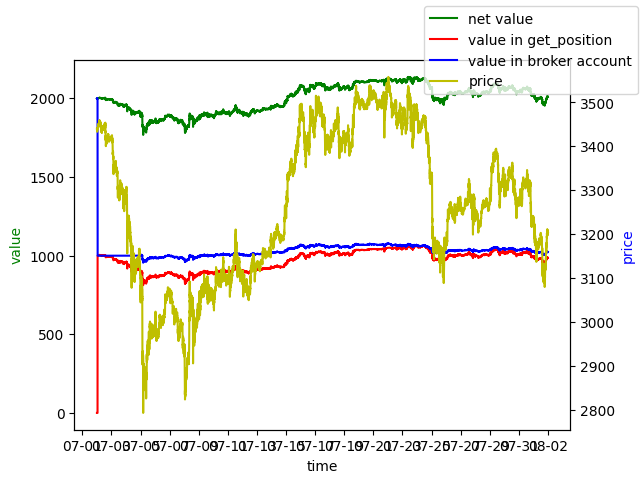

In [37]:
run_strategy()

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_80905/242916292.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


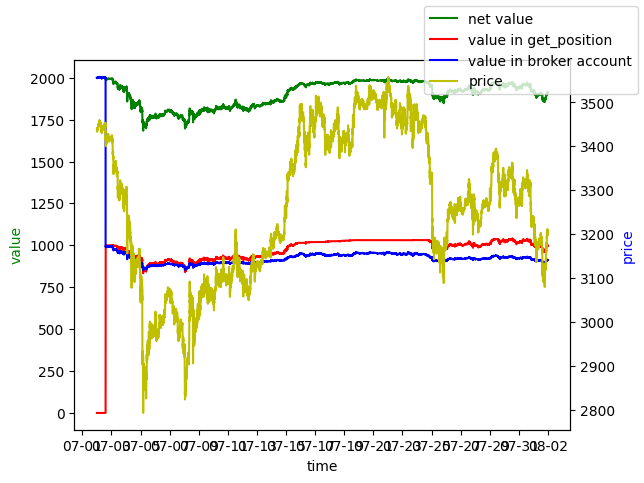